In [ ]:

%pip install tensorflow==2.4

In [ ]:
%pip install n2v

In [ ]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

In [ ]:
# import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
from PIL import Image
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**Training Data Preparation**


<p>
For training we can load a bunch of noisy images from a directory. Images can be of different sizes as we will be capturing them as a list, not an array. Of course, each image is an array. We will use the N2V_DataGenerator to extract training X and validation X_val patches.

In [3]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

If you have many images stored in a directory, use load_imgs_from_directory method to load them into a list. Images can be of different sizes as we are capturing them into a list, not an array.
<p>
You can also use your favorite way of reading images (e.g., using skimage) sequentially and capturing them into a list that can be used as input to the network.
<p>
Note that the images need to be in float32 format. load_imgs_from_directory method converts images to float32 but if you use your own way of loading images, you need to make sure they are converted to float32.

In [ ]:
# #METHOD 1: Loading images using load_imgs_from_directory method
# # We load all the '.png' files from the directory.
# # The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "C:/Users/Dell/Desktop/n2v/ddn", filter='*.tiff',dims='YX')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',len(imgs))
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)
# import os
# import datagen  # Assuming this is your image loading module
# directory = "C:/Users/Dell/Desktop/n2v/ICIP training data/0/RawDataQA (1)"

# def get_image_paths(directory, filter='*.tiff'):
#     # List to store all image paths
#   image_paths = []
#   for root, _, files in os.walk(directory):
#     for file in files:
#         if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
#             image_paths.append(os.path.join(root, file))
    
#   return image_paths

# def load_greyscale_images(image_paths):
#     images = []
    
#     for path in image_paths:
#         try:
#             # Open the image, convert to greyscale, and convert to a NumPy array
#             image = Image.open(path).convert('L')
#             image_array = np.array(image)
#             images.append(image_array)
#         except Exception as e:
#             print(f"Error loading image {path}: {e}")
    
#     return images

# Directory containing images and subdirectories

# Get all image paths
# imgs = get_image_paths(directory, filter='*.tiff')
# imgs = load_greyscale_images(imgs)
# imgs = 

# print(f"Loaded {len(imgs)} images matching the pattern '*.tiff'")



In [ ]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

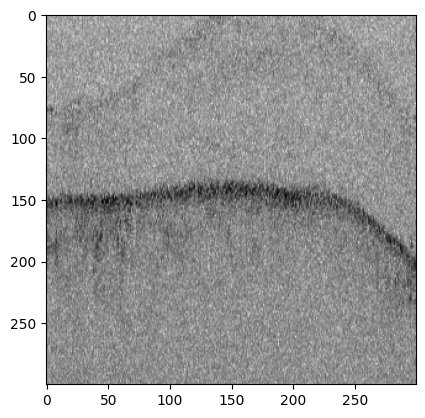

In [6]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[0][0,:,:,:], cmap = "binary")
plt.show()

In [7]:
patch_size = 64

In [ ]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


In [9]:
patches.shape

(17152, 64, 64, 1)

In [10]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.2)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

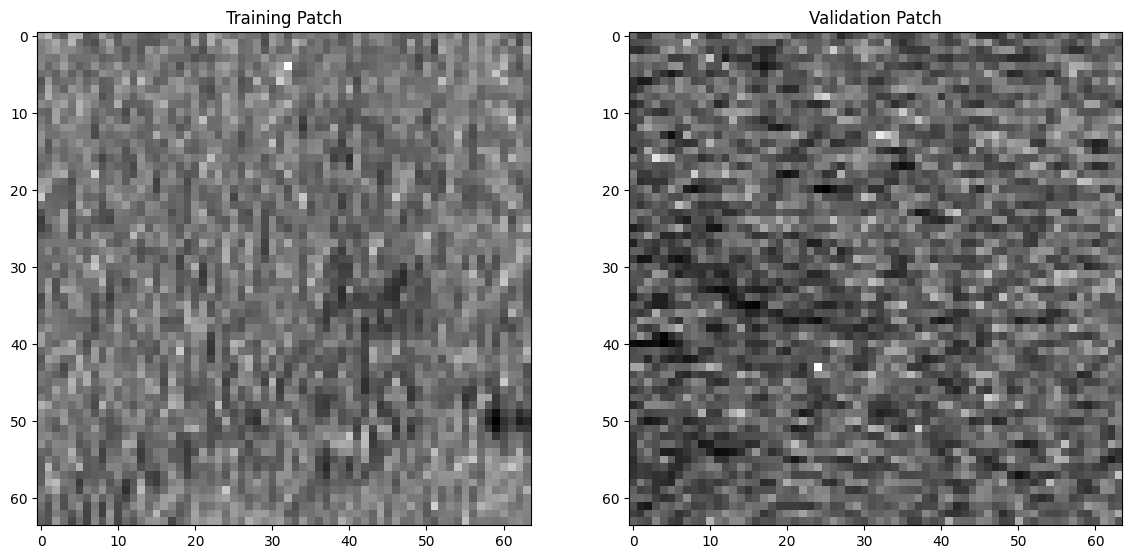

In [13]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...], cmap = "binary")
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...], cmap = "binary")
plt.title('Validation Patch');

<h2>Configure</h2><p>

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.
<p>
When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.
<p>
Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.
<p>
<h3>Other pixel manipulators:</h3>
<p>
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
<br>
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
<br>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
<br>
* identity: performs no pixel manipulation
<br>
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.
<p>
For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).
<p>
In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.<br>
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.
<p>
**Warning:** to make this example notebook execute faster, we have set train_epochs to only 10.
For better results we suggest 100 to 200 train_epochs.

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=5, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

In [ ]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

<h2>Training</h2><p>


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


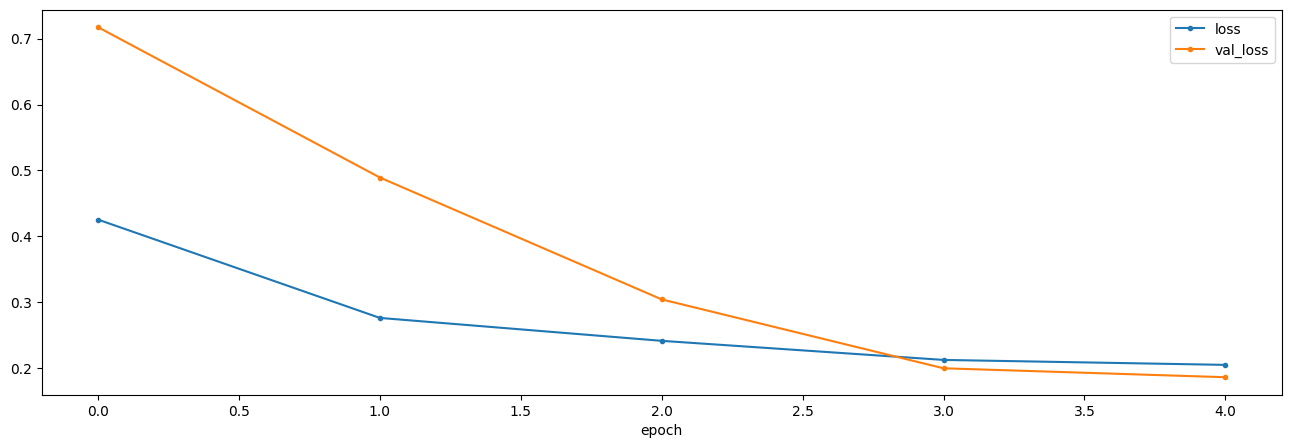

In [17]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

<h1>Denoising images using the trained model</h1>

In [ ]:
# model.save('model_1.h5')

In [19]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [20]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [22]:
# We load the data we want to process.
img = imread('C:/Users/Dell/Desktop/n2v/RawDataQA31 (1).tiff')
img.dtype

dtype('uint8')

In [25]:
imgs1 = datagen.load_imgs_from_directory(directory = "C:/Users/Dell/Desktop/n2v/test_images", filter='*.tiff',dims='YX')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',len(imgs1))
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs1[0] = imgs1[0][...,:3]
print('shape without alpha:    ',imgs1[0].shape)
print('The data type of the first image is: ', imgs1[0].dtype)

shape of loaded images:  1
shape without alpha:     (1, 300, 300, 1)
The data type of the first image is:  float32


In [ ]:
print(imgs1[0])

In [ ]:

# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
# img = img[...,:3]
pred = model.predict(imgs1[0][0,:,:,:], axes='YXC')



In [ ]:
pred.shape

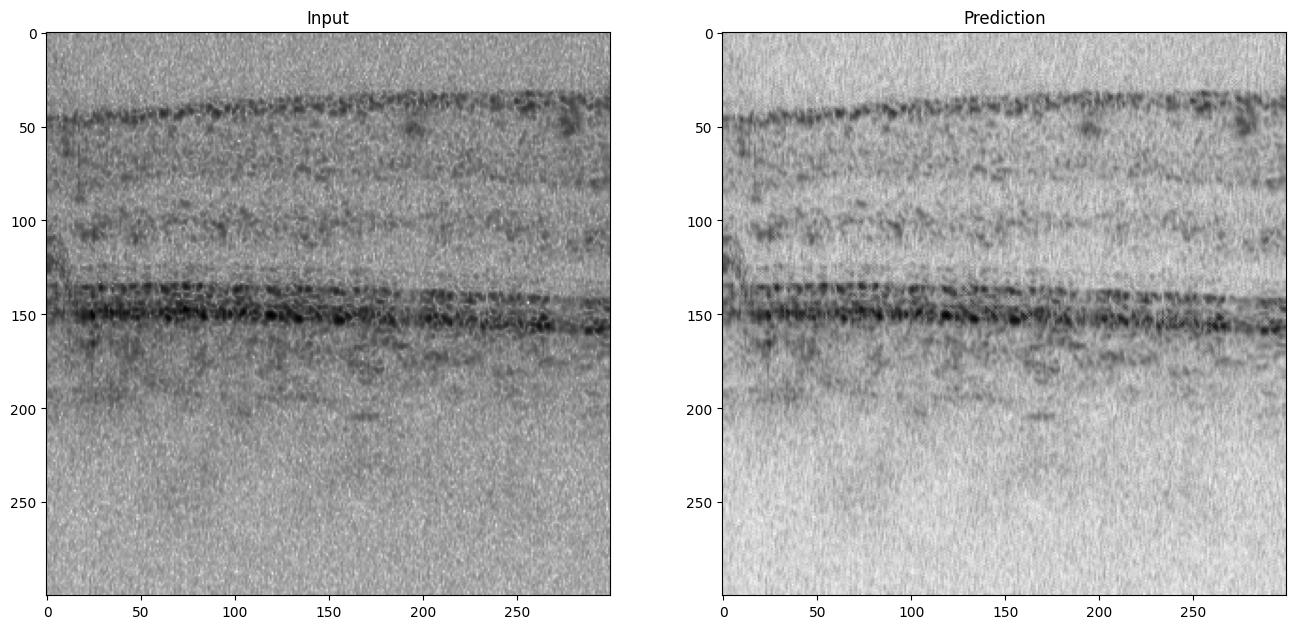

In [34]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(imgs1[0][0,:,:,:], cmap = "binary")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred, cmap = "binary")
plt.title('Prediction');

In [36]:
save_tiff_imagej_compatible('pred_train.tiff', pred, axes='YXC')